In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc

In [4]:
folder_path = "interactions\\interactions\\6\\6"
file_names = [
    "2024-11-21.csv",
    "2024-11-22.csv",
    "2024-11-23.csv",
    "2024-11-24.csv",
    "2024-11-25.csv",
    "2024-11-26.csv",
    "2024-11-27.csv"
]

merged = pd.DataFrame()

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    merged = pd.concat([merged, data], ignore_index=True)

In [6]:
df = merged[['customer_key','site_id', 'start_time', 'end_time', 'transaction_id', 'product', 'dtl_1_num', 'dtl_1_char', 'dtl_2_num', 'dtl_2_char']]
print(df.shape)
display(df.head())

(11679218, 10)


,customer_key,site_id,start_time,end_time,transaction_id,product,dtl_1_num,dtl_1_char,dtl_2_num,dtl_2_char
0,117818112,126,2024-11-21 03:03:35.515,2024-11-21 03:03:35.515,6_126_38044012_84fa2052-d356-489d-b3fc-a1dcd46...,U,0,coxconnectuser,0,no_outage
1,112847896,126,2024-11-21 13:49:03.052,2024-11-21 13:49:03.052,6_126_38930102_ab8cfa36-20c7-4b99-b8a4-993d7ae...,"C,D,T",1,ccmuser,0,plan_mnt
2,117182516,126,2024-11-21 13:25:28.603,2024-11-21 13:25:28.603,6_126_49078401_77f136ff-2ef7-449f-9c4c-4888a0b...,"C,D,T",1,proactive_outage_notification,0,unplan_event
3,114433134,126,2024-11-21 15:44:03.507,2024-11-21 15:44:03.507,6_126_66323110_e5132f84-006b-41b9-9fe6-61a4fba...,U,0,ccmuser,0,no_outage
4,102419120,131,2024-11-21 04:33:02.931,2024-11-21 04:33:02.931,6_131_36216503_a0a2ccc5-a121-47b5-beed-279ce91...,U,0,ccmuser,0,no_outage


In [249]:
# Copy relevant columns
y = df[['site_id', 'start_time', 'end_time', 'dtl_1_num', 'dtl_1_char', 'dtl_2_num', 'dtl_2_char']].copy()

# Convert start_time to datetime
y.loc[:, 'start_time'] = pd.to_datetime(y['start_time'])

# Set start_time as index
y.set_index('start_time', inplace=True)

# Perform resampling without groupby by site_id
aggregated_overall = (
    y.resample('15min')  # Resample by 1 minute
    .agg(
        system_outage_count=('dtl_1_num', 'sum'),  # Sum of system outages
        customer_outage_count=('dtl_2_num', 'sum'),  # Sum of customer reported outages
        interaction_volume=('dtl_1_num', 'count')  # Count of interactions in that minute
    )
    .reset_index()  # Reset index after resampling
)


C:\Users\andre\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [253]:
aggregated_overall['system_outage_percent']=aggregated_overall['system_outage_count']/aggregated_overall['interaction_volume']

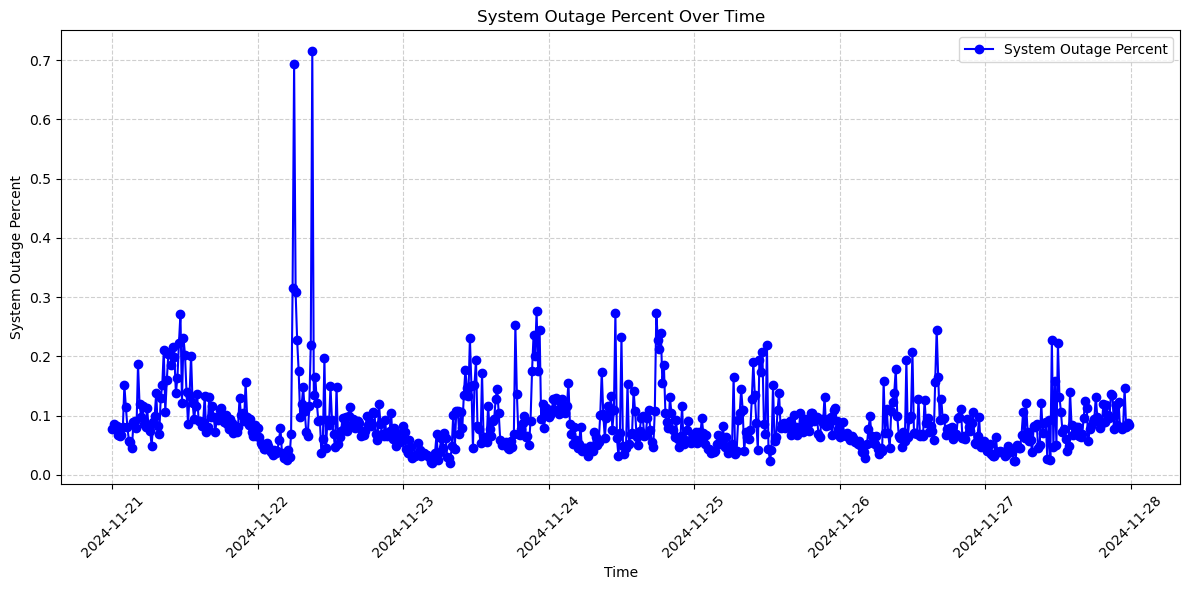

In [257]:
# Plot system_outage_percent over time
plt.figure(figsize=(12, 6))
plt.plot(aggregated_overall['start_time'], aggregated_overall['system_outage_percent'], color="blue", linestyle='-', marker='o', label="System Outage Percent")

# Customize the plot
plt.xlabel("Time")
plt.ylabel("System Outage Percent")
plt.title("System Outage Percent Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [295]:
y = df[['site_id', 'start_time', 'end_time', 'dtl_1_num','dtl_1_char', 'dtl_2_num','dtl_2_char']].copy()
y.loc[:, 'start_time'] = pd.to_datetime(y['start_time'])

y.set_index('start_time', inplace=True)
aggregated = pd.DataFrame()
aggregated = (
    y.groupby('site_id')  # groupby side
    .resample('1H')        # 按每分钟进行重采样 ('1T' 表示 1 分钟)
    .agg(
        system_outage_count=('dtl_1_num', 'sum'),  # 统计系统监测 outage 的数量
        customer_outage_count=('dtl_2_num', 'sum'),  # 统计用户报告的 outage 数量
        interaction_volume=('dtl_1_num', 'count')  # 统计该分钟的总交互量
    )
    .reset_index()  # 将索引重置为普通列
)


C:\Users\andre\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\andre\AppData\Local\Temp\ipykernel_30892\162957000.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('1H')        # 按每分钟进行重采样 ('1T' 表示 1 分钟)


In [299]:
y['start_time']=y.index

In [301]:
y['start_time']=(y['start_time']).dt.strftime("%Y-%m-%d %H")

In [ ]:
# make dtl_1_char
# outliers
# change time range from 1 min, 2 min, ...


In [305]:
aggregated['system_outage_percent']=aggregated['system_outage_count']/aggregated['interaction_volume']

In [271]:
import seaborn as sns

In [511]:
# Pivot the data to get site_id as rows, time as columns, and system_outage_percent as values
heatmap_data = aggregated[aggregated['start_time'].dt.date == pd.to_datetime('2024-11-21').date()].pivot_table(
    index='site_id',  # Rows: site_id
    columns='start_time',  # Columns: start_time
    values='system_outage_percent',  # Values: system_outage_percent
    aggfunc='mean'  # In case there are multiple entries for a site_id at a given time
)

heatmap_data = heatmap_data.fillna(0)

<Axes: xlabel='start_time', ylabel='site_id'>

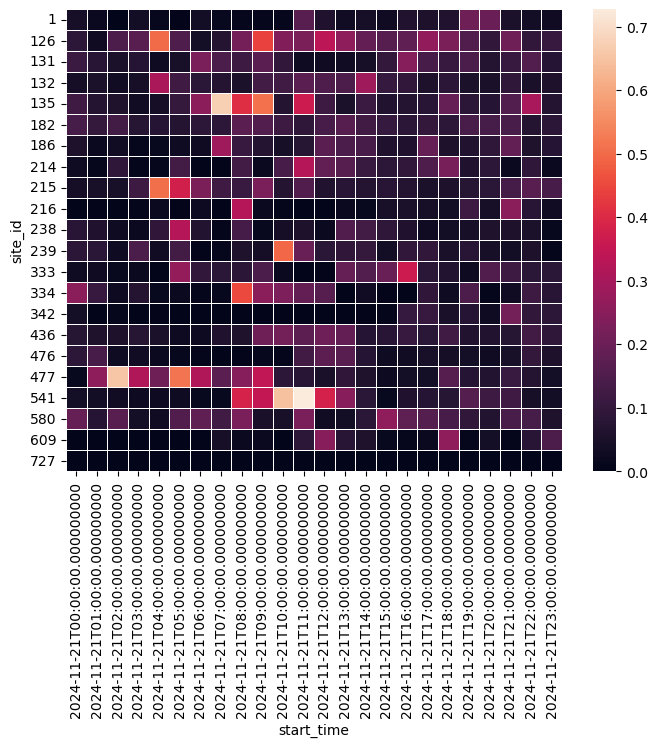

In [513]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    # cmap="YlGnBu",  # Color map for the heatmap
    # cbar_kws={'label': 'System Outage Percent'},  # Color bar label
    annot=False,  # No annotations in the cells
    fmt=".2f",  # Format values to 2 decimal places
    linewidths=0.5  # Line width for separating cells
)

# # Customize plot
# plt.title("Heatmap of System Outage Percent Over Time (Grouped by Site ID)")
# plt.xlabel("Time")
# plt.ylabel("Site ID")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [103]:
aggregated_clean=aggregated[aggregated['interaction_volume']>0]

In [111]:
aggregated_clean["day_of_week"] = aggregated_clean["start_time"].dt.strftime('%a')
aggregated_clean["hour"] = aggregated_clean["start_time"].dt.hour

C:\Users\andre\AppData\Local\Temp\ipykernel_30892\3645211676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_clean["day_of_week"] = aggregated_clean["start_time"].dt.strftime('%a')
C:\Users\andre\AppData\Local\Temp\ipykernel_30892\3645211676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_clean["hour"] = aggregated_clean["start_time"].dt.hour


In [131]:
aggregated_clean["day_of_week"] = aggregated_clean["day_of_week"].astype("category")
aggregated_clean["hour"] = aggregated_clean["hour"].astype("category")
aggregated_clean["system_outage_binary"] = (aggregated_clean["system_outage_percent"] > 0).astype(int)  # Convert to binary response

C:\Users\andre\AppData\Local\Temp\ipykernel_30892\2969688259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_clean["day_of_week"] = aggregated_clean["day_of_week"].astype("category")
C:\Users\andre\AppData\Local\Temp\ipykernel_30892\2969688259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_clean["hour"] = aggregated_clean["hour"].astype("category")
C:\Users\andre\AppData\Local\Temp\ipykernel_30892\2969688259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [133]:
# One-hot encode categorical variables
encoder = OneHotEncoder()
encoded_cats = encoder.fit_transform(aggregated_clean[["hour", "day_of_week"]]).toarray()
encoded_features = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(["hour", "day_of_week"]))
aggregated_clean_encoded = pd.concat([aggregated_clean.reset_index(drop=True), encoded_features], axis=1)

In [135]:
split_date = aggregated_clean["start_time"].iloc[int(len(aggregated_clean) * 0.8)]  # Use 80% for training, 20% for testing
train_data = aggregated_clean_encoded[aggregated_clean_encoded["start_time"] < split_date]
test_data = aggregated_clean_encoded[aggregated_clean_encoded["start_time"] >= split_date]

In [155]:
X_train = train_data.drop(columns=["start_time", "system_outage_count","customer_outage_count","system_outage_percent", "system_outage_binary", "site_id", "day_of_week", "hour"])
y_train = train_data["system_outage_binary"]
X_test = test_data.drop(columns=["start_time", "system_outage_count","customer_outage_count", "system_outage_percent", "system_outage_binary", "site_id", "day_of_week", "hour"])
y_test = test_data["system_outage_binary"]

In [159]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [161]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [165]:
coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_[0]
})

print(coefficients)

               Feature  Coefficient
0   interaction_volume     0.044261
1                  day    -0.066936
2               hour_0    -0.087136
3               hour_1    -0.226994
4               hour_2    -0.349945
5               hour_3    -0.499743
6               hour_4    -0.570706
7               hour_5    -0.463570
8               hour_6    -0.437851
9               hour_7    -0.343786
10              hour_8    -0.217860
11              hour_9    -0.085531
12             hour_10    -0.076657
13             hour_11     0.016757
14             hour_12     0.042144
15             hour_13     0.199381
16             hour_14     0.242016
17             hour_15     0.315283
18             hour_16     0.300426
19             hour_17     0.434611
20             hour_18     0.363446
21             hour_19     0.353282
22             hour_20     0.268463
23             hour_21     0.330155
24             hour_22     0.381074
25             hour_23     0.091881
26     day_of_week_Fri    -0

AUC: 0.8708923923299703


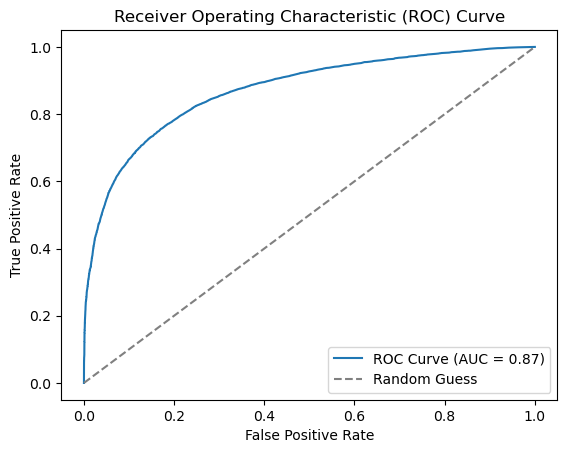

In [171]:
y_prob = model.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

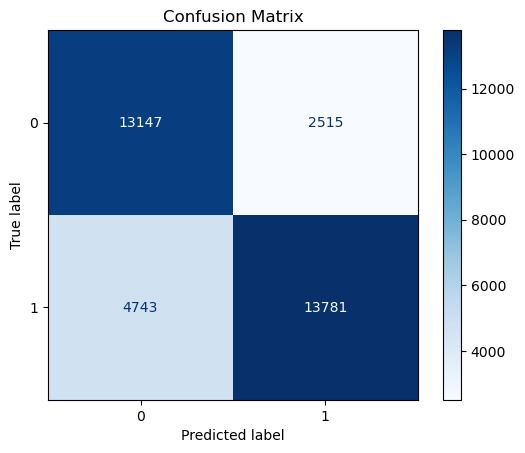

In [177]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [195]:
test_data['system_outage_pred']=y_prob

C:\Users\andre\AppData\Local\Temp\ipykernel_30892\1559426544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['system_outage_pred']=y_prob


In [233]:
# Add predicted probabilities to test_data (scaled to percentages)
test_data["system_outage_pred"] = y_prob  # Scale probabilities to percentages

# Define bins for grouping (0 to 100 with step size 0.1)
bins = np.arange(0, test_data["system_outage_percent"].max() + 0.1, 0.1)
test_data["outage_group"] = pd.cut(test_data["system_outage_percent"], bins=bins, right=False)

# Group by outage_group and calculate the mean of system_outage_pred
grouped_data = test_data.groupby("outage_group")["system_outage_pred"].mean().reset_index()

C:\Users\andre\AppData\Local\Temp\ipykernel_30892\3169119138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["system_outage_pred"] = y_prob  # Scale probabilities to percentages
C:\Users\andre\AppData\Local\Temp\ipykernel_30892\3169119138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["outage_group"] = pd.cut(test_data["system_outage_percent"], bins=bins, right=False)
C:\Users\andre\AppData\Local\Temp\ipykernel_30892\3169119138.py:9: FutureWarning: The default of observed=False 

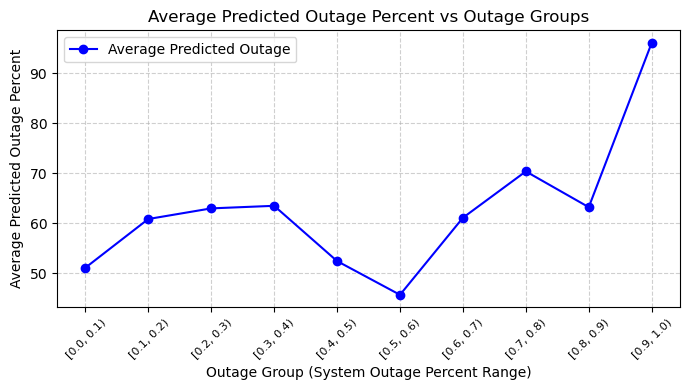

In [215]:
# Plot outage_group vs system_outage_pred
plt.figure(figsize=(7, 4))
plt.plot(
    grouped_data["outage_group"].astype(str),  # Convert bins to string for better readability
    grouped_data["system_outage_pred"],
    marker="o",
    linestyle="-",
    color="blue",
    label="Average Predicted Outage"
)

# Customize the plot
plt.xlabel("Outage Group (System Outage Percent Range)")
plt.ylabel("Average Predicted Outage Percent")
plt.title("Average Predicted Outage Percent vs Outage Groups")
plt.xticks(rotation=45, fontsize=8)  # Rotate x-axis labels for clarity
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [235]:
# Define bins for grouping (0 to 100 with step size 0.1)
bins_pred = np.arange(0, test_data["system_outage_pred"].max() + 0.1, 0.1)
test_data["pred_group"] = pd.cut(test_data["system_outage_pred"], bins=bins_pred, right=False)

# Group by pred_group and calculate the mean of system_outage_percent
grouped_by_pred = test_data.groupby("pred_group")["system_outage_percent"].mean().reset_index()

C:\Users\andre\AppData\Local\Temp\ipykernel_30892\764408862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["pred_group"] = pd.cut(test_data["system_outage_pred"], bins=bins_pred, right=False)
C:\Users\andre\AppData\Local\Temp\ipykernel_30892\764408862.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_pred = test_data.groupby("pred_group")["system_outage_percent"].mean().reset_index()


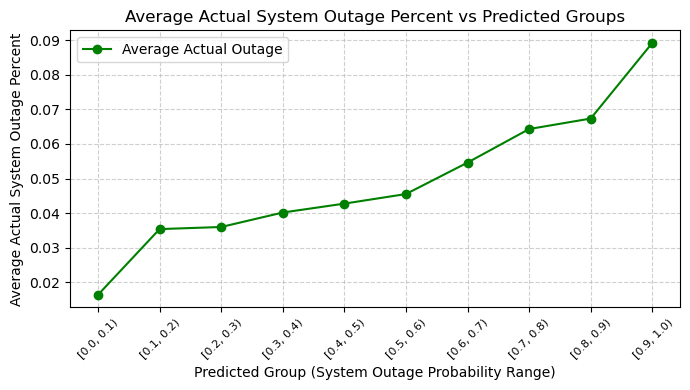

In [239]:
# Plot pred_group vs system_outage_percent
plt.figure(figsize=(7, 4))
plt.plot(
    grouped_by_pred["pred_group"].astype(str),  # Convert bins to string for better readability
    grouped_by_pred["system_outage_percent"],
    marker="o",
    linestyle="-",
    color="green",
    label="Average Actual Outage"
)

# Customize the plot
plt.xlabel("Predicted Group (System Outage Probability Range)")
plt.ylabel("Average Actual System Outage Percent")
plt.title("Average Actual System Outage Percent vs Predicted Groups")
plt.xticks(rotation=45, fontsize=8)  # Rotate x-axis labels for better visibility
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\andre\AppData\Local\Temp\ipykernel_30892\3812961070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['start_time'] = pd.to_datetime(test_data['start_time'])


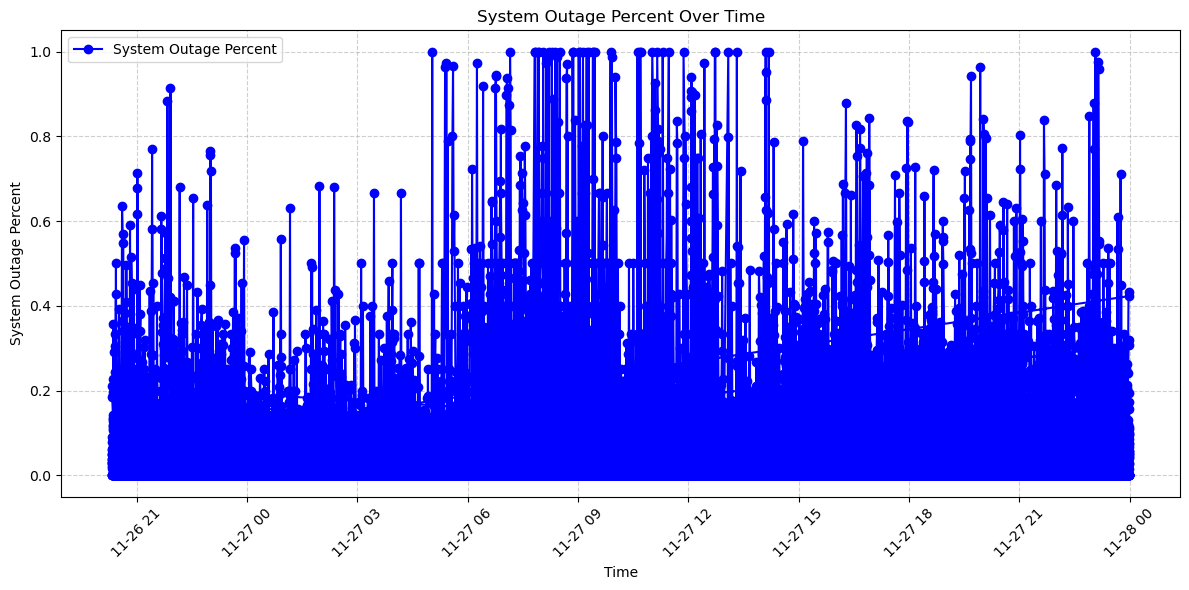

In [241]:
# Ensure that 'start_time' is a datetime object
test_data['start_time'] = pd.to_datetime(test_data['start_time'])

# Plot system_outage_percent over time
plt.figure(figsize=(12, 6))
plt.plot(test_data['start_time'], test_data['system_outage_percent'], color="blue", marker="o", linestyle='-', label="System Outage Percent")

# Customize the plot
plt.xlabel("Time")
plt.ylabel("System Outage Percent")
plt.title("System Outage Percent Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [487]:
test_data_1=test_data[test_data['site_id']==541].reset_index(drop=True)

In [561]:
# Define the target mean and threshold for positive CUSUM
target_mean = 0.9  # Target mean (can be adjusted)
threshold =  25 # Threshold for positive CUSUM to detect change (can be adjusted)

# Initialize the CUSUM with 0 for the first observation
test_data_1['cusum_pos'] = 0.0  # Start with 0
for t in range(1, len(test_data_1)):
    test_data_1.loc[t, 'cusum_pos'] = max(0, test_data_1.loc[t-1, 'cusum_pos'] + test_data_1.loc[t, 'system_outage_pred'] - target_mean)

# Flag changes when positive CUSUM exceeds the threshold
test_data_1['change_detected'] = np.where(test_data_1['cusum_pos'] > threshold, 1, 0)

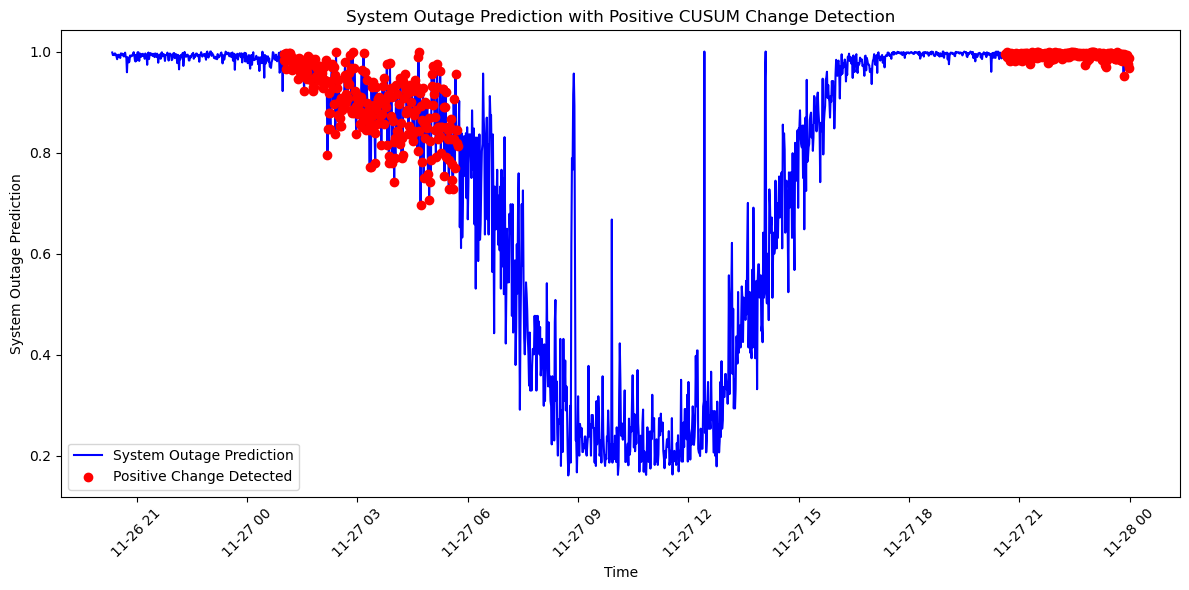

In [563]:
# Plot the system_outage_pred over time
plt.figure(figsize=(12, 6))
plt.plot(test_data_1['start_time'], test_data_1['system_outage_pred'], label='System Outage Prediction', color='blue')

# Highlight points where a positive change is detected
change_points = test_data_1[test_data_1['change_detected'] == 1]
plt.scatter(change_points['start_time'], change_points['system_outage_pred'], color='red', label='Positive Change Detected', zorder=5)

# Labels and title
plt.xlabel('Time')
plt.ylabel('System Outage Prediction')
plt.title('System Outage Prediction with Positive CUSUM Change Detection')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

### Node Level

In [7]:
csv_files = [file for file in os.listdir('customers_dim') if file.endswith('.csv')]

In [11]:
directory = 'customers_dim'

In [13]:
customers_dim = pd.concat(
    [pd.read_csv(os.path.join(directory, file)) for file in csv_files], 
    ignore_index=True
)

In [17]:
df_node=pd.merge(df,customers_dim[['customer_key','node']])

In [19]:
df_node['site_node']=df_node['site_id'].astype(str)+'_'+df_node['node'].astype(str)

In [21]:
df_node['start_time'] = pd.to_datetime(df_node['start_time'])

In [25]:
df_node_aggregated = (
    df_node
    .groupby([df_node['site_node'],df_node['start_time'].dt.floor('T')])
    .agg({'dtl_1_num':'sum','transaction_id': 'count'})
    .reset_index()
    .rename(columns={'start_time': 'minute_start', 'transaction_id': 'total_invocations'})
)

C:\Users\andre\AppData\Local\Temp\ipykernel_18316\340882244.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .groupby([df_node['site_node'],df_node['start_time'].dt.floor('T')])


In [29]:
import numpy as np

In [31]:
df_node_aggregated['is_outage']=np.where(df_node_aggregated['dtl_1_num']/df_node_aggregated['total_invocations']>=0.5,1,0)

In [33]:
aggregated_df_node=(df_node_aggregated
    .groupby(df_node_aggregated['site_node'])
    .agg({'total_invocations': 'sum'})
    .reset_index()
)

In [35]:
# Define the bin range (increments of 5, from 0 to 2000)
bin_edges = range(0, 2005, 5)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(aggregated_df_node['total_invocations'], bins=bin_edges, alpha=0.7)

# Set x-axis range from 0 to 2000
plt.xlim(0, 2000)

# Add titles and labels
plt.title('Histogram of Total Invocations', fontsize=14)
plt.xlabel('Total Invocations (Bin Range: 5)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show gridlines and the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

NameError: name 'plt' is not defined

In [37]:
from sklearn.cluster import KMeans

In [39]:
X = aggregated_df_node[['total_invocations']]

In [41]:
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Clusters', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.xticks(k_range)
plt.grid(alpha=0.5)
plt.show()

NameError: name 'plt' is not defined

In [45]:
kmeans = KMeans(n_clusters=10, random_state=42)
aggregated_df_node['cluster'] = kmeans.fit_predict(X)


# Visualize the clusters
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Use a colormap for distinct cluster colors

for cluster_id in aggregated_df_node['cluster'].unique():
    cluster_data = aggregated_df_node[aggregated_df_node['cluster'] == cluster_id]
    plt.scatter(
        cluster_data['total_invocations'],
        [cluster_id] * len(cluster_data),
        color=colors[cluster_id % len(colors)],
        label=f'Cluster {cluster_id}',
        s=100  # Set marker size
    )

# # Add centroids to the plot
# centroids = kmeans.cluster_centers_
# plt.scatter(centroids, range(7), color='red', marker='X', s=200, label='Centroids')

# Customize plot
plt.title('Clustering of Nodes Based on Total Invocations (k=7)', fontsize=14)
plt.xlabel('Total Invocations', fontsize=12)
plt.ylabel('Cluster ID', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

NameError: name 'plt' is not defined

In [47]:
df_node_clean=pd.merge(df_node_aggregated,aggregated_df_node[['site_node','cluster']]).drop(columns={'dtl_1_num'})

In [49]:
# Create new columns: 'day_of_week' and 'hour'
df_node_clean['day_of_week'] = df_node_clean['minute_start'].dt.day_name()  # Day of the week (e.g., Monday, Tuesday)
df_node_clean['hour'] = df_node_clean['minute_start'].dt.hour  # Hour (0-23)

In [55]:
# One-Hot Encoding for categorical variables: 'cluster', 'day_of_week', 'hour'
encoder = OneHotEncoder(sparse_output=False)

In [57]:
# Apply one-hot encoding on categorical columns
categorical_features = ['cluster', 'day_of_week', 'hour']
encoded_features = encoder.fit_transform(df_node_clean[categorical_features])

In [59]:
# Convert encoded features to DataFrame and concatenate
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df_node_clean = pd.concat([df_node_clean, encoded_df], axis=1)

In [69]:
train_df = df_node_clean[df_node_clean['minute_start'] <= '2024-11-26']
test_df = df_node_clean[df_node_clean['minute_start'] > '2024-11-27']

In [73]:
X_train = train_df.drop(['site_node', 'is_outage', 'minute_start','cluster','day_of_week','hour'], axis=1)
y_train = train_df['is_outage']
X_test = test_df.drop(['site_node', 'is_outage', 'minute_start','cluster','day_of_week','hour'], axis=1)
y_test = test_df['is_outage']

In [75]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\andre\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [79]:
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
20111/20111 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step - accuracy: 0.9538 - loss: 0.1591 - val_accuracy: 0.9506 - val_loss: 0.1782
Epoch 2/10
20111/20111 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.9548 - loss: 0.1526 - val_accuracy: 0.9503 - val_loss: 0.1741
Epoch 3/10
20111/20111 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.9550 - loss: 0.1519 - val_accuracy: 0.9508 - val_loss: 0.1750
Epoch 4/10
20111/20111 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.9550 - loss: 0.1518 - val_accuracy: 0.9511 - val_loss: 0.1733
Epoch 5/10
20111/20111 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - accuracy: 0.9550 - loss: 0.1519 - val_accuracy: 0.9502 - val_loss: 0.1736
Epoch 6/10
20111/20111 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - accuracy: 0.9550 - loss: 0.1519 - val_accuracy: 0.9509 - val_loss: 0.1722
Epoch 7/10
20111/20111 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.9552 - loss: 0.1514 - val_accuracy: 0.9508 - val_loss: 0.1723
Epoch 8/10
20111/20111 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - accuracy: 

In [83]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Predict using the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert to 0 or 1 based on threshold

# Print predictions for the test set
print(y_pred)

34442/34442 ━━━━━━━━━━━━━━━━━━━━ 27s 779us/step - accuracy: 0.9513 - loss: 0.1685
Test Accuracy: 95.09%
34442/34442 ━━━━━━━━━━━━━━━━━━━━ 16s 466us/step
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [93]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9509
Precision: 0.5570
Recall: 0.1099
F1-score: 0.1836


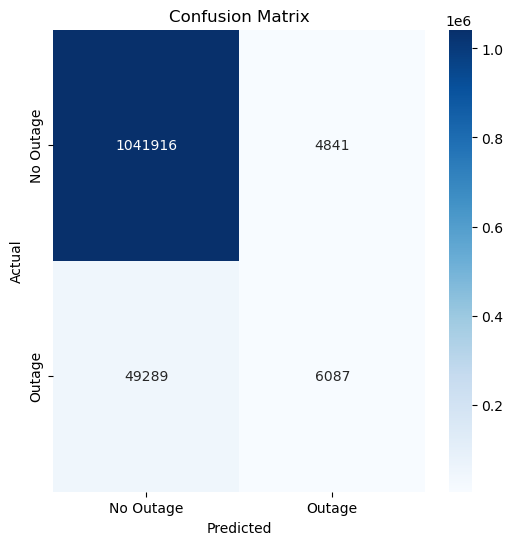

In [103]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Outage', 'Outage'], yticklabels=['No Outage', 'Outage'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Using 30-minute Rolling Data

In [53]:
df_rolling=pd.read_csv('7d_5min_alldummies_rolling.csv')

In [12]:
# df_rolling['is_outage']=np.where(df_rolling['system_outage_count']>0,1,0)

In [55]:
train_data, test_data = train_test_split(df_rolling, test_size=0.2, random_state=42)

In [61]:
X_train = train_data.drop(['customer_key', 'node_id','system_outage_count','outage'], axis=1)
y_train = train_data['outage']
X_test = test_data.drop(['customer_key', 'node_id','system_outage_count','outage'], axis=1)
y_test = test_data['outage']

In [63]:
X_train.columns

Index(['interaction_volume', 'custom_msg_count', 'cbuser_count',
       'ccmuser_count', 'coxcnsuser_count', 'coxconnectuser_count',
       'digitalassistbotuser_count', 'fsmobilityuser_count', 'ibilluser_count',
       'icesdtwsuser_count', 'icomsuser_count', 'IAE_count',
       'ivravayauser_count', 'pinpointuser_count', 'lob_C', 'lob_R',
       'system_outage_count_30min_sum', 'cbuser_count_30min_sum',
       'ccmuser_count_30min_sum', 'coxcnsuser_count_30min_sum',
       'coxconnectuser_count_30min_sum',
       'digitalassistbotuser_count_30min_sum',
       'fsmobilityuser_count_30min_sum', 'ibilluser_count_30min_sum',
       'icesdtwsuser_count_30min_sum', 'icomsuser_count_30min_sum',
       'IAE_count_30min_sum', 'ivravayauser_count_30min_sum',
       'pinpointuser_count_30min_sum', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'time_period_midnight_to_noon_UTC', 'time_period_noon_to_midnight_UTC'],
      dtype='object')

In [65]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\andre\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [69]:
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
19568/19568 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9828 - loss: 0.0663 - val_accuracy: 0.9871 - val_loss: 0.0540
Epoch 2/10
19568/19568 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.9870 - loss: 0.0544 - val_accuracy: 0.9871 - val_loss: 0.0541
Epoch 3/10
19568/19568 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.9872 - loss: 0.0538 - val_accuracy: 0.9871 - val_loss: 0.0536
Epoch 4/10
19568/19568 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - accuracy: 0.9872 - loss: 0.0535 - val_accuracy: 0.9872 - val_loss: 0.0532
Epoch 5/10
19568/19568 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - accuracy: 0.9872 - loss: 0.0537 - val_accuracy: 0.9872 - val_loss: 0.0536
Epoch 6/10
19568/19568 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - accuracy: 0.9871 - loss: 0.0535 - val_accuracy: 0.9872 - val_loss: 0.0532
Epoch 7/10
19568/19568 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.9872 - loss: 0.0534 - val_accuracy: 0.9872 - val_loss: 0.0530
Epoch 8/10
19568/19568 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 

In [71]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Predict using the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert to 0 or 1 based on threshold

# Print predictions for the test set
print(y_pred)

39135/39135 ━━━━━━━━━━━━━━━━━━━━ 34s 880us/step - accuracy: 0.9873 - loss: 0.0523
Test Accuracy: 98.72%
39135/39135 ━━━━━━━━━━━━━━━━━━━━ 21s 541us/step
[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]]


In [73]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9872
Precision: 0.9225
Recall: 0.8606
F1-score: 0.8905


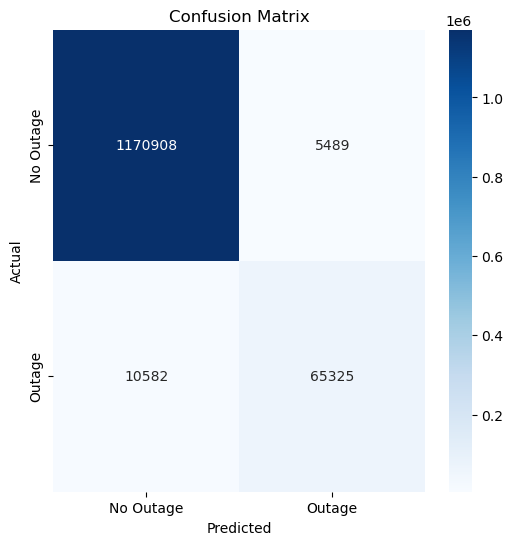

In [75]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Outage', 'Outage'], yticklabels=['No Outage', 'Outage'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

39135/39135 ━━━━━━━━━━━━━━━━━━━━ 22s 550us/step


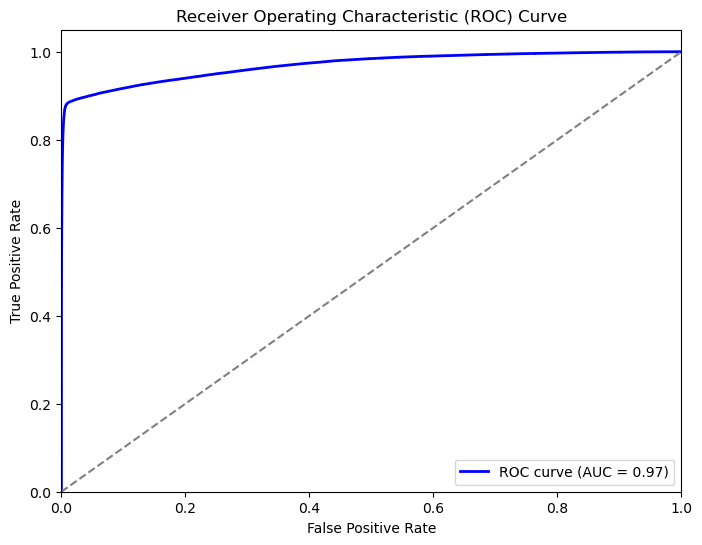

In [79]:
# Predict probabilities (for AUC/ROC, use predicted probabilities, not binary predictions)
y_pred_prob = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Deep Learning Using 90D Data

In [6]:
df_90d=pd.read_csv('90d_sampled_agg.csv')

In [8]:
train_data, test_data = train_test_split(df_90d, test_size=0.2, random_state=42)

In [14]:
df_90d.columns

Index(['customer_key', 'node_id', 'outage', 'interaction_volume',
       'custom_msg_count', 'cbuser_count', 'ccmuser_count', 'coxcnsuser_count',
       'coxconnectuser_count', 'digitalassistbotuser_count',
       'fsmobilityuser_count', 'ibilluser_count', 'icesdtwsuser_count',
       'icomsuser_count', 'IAE_count', 'ivravayauser_count',
       'pinpointuser_count', 'solcenuser_count', 'lob_C', 'lob_R',
       'work_order_count', 'outage_count_30min_sum', 'cbuser_count_30min_sum',
       'ccmuser_count_30min_sum', 'coxcnsuser_count_30min_sum',
       'coxconnectuser_count_30min_sum',
       'digitalassistbotuser_count_30min_sum',
       'fsmobilityuser_count_30min_sum', 'ibilluser_count_30min_sum',
       'icesdtwsuser_count_30min_sum', 'icomsuser_count_30min_sum',
       'IAE_count_30min_sum', 'ivravayauser_count_30min_sum',
       'pinpointuser_count_30min_sum', 'solcenuser_count_30min_sum',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', '

In [16]:
X_train = train_data.drop(['customer_key', 'node_id','outage'], axis=1)
y_train = train_data['outage']
X_test = test_data.drop(['customer_key', 'node_id','outage'], axis=1)
y_test = test_data['outage']

In [26]:
# Ensure X_train and X_test are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Ensure y_train and y_test are integers (if classification)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [18]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\andre\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
y_train.head()

1640545    0
9790734    0
870808     0
6662004    1
356948     0
Name: outage, dtype: int64

In [30]:
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.9621 - loss: 0.1541 - val_accuracy: 0.9627 - val_loss: 0.1502
Epoch 2/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.9628 - loss: 0.1497 - val_accuracy: 0.9627 - val_loss: 0.1500
Epoch 3/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9629 - loss: 0.1496 - val_accuracy: 0.9627 - val_loss: 0.1499
Epoch 4/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9629 - loss: 0.1493 - val_accuracy: 0.9627 - val_loss: 0.1501
Epoch 5/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9629 - loss: 0.1493 - val_accuracy: 0.9627 - val_loss: 0.1499
Epoch 6/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.9629 - loss: 0.1494 - val_accuracy: 0.9627 - val_loss: 0.1498
Epoch 7/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.9629 - loss: 0.1492 - val_accuracy: 0.9627 - val_loss: 0.1498
Epoch 8/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 

In [34]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Predict using the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert to 0 or 1 based on threshold

# Print predictions for the test set
print(y_pred)

62499/62499 ━━━━━━━━━━━━━━━━━━━━ 87s 1ms/step - accuracy: 0.9625 - loss: 0.1505
Test Accuracy: 96.27%
62499/62499 ━━━━━━━━━━━━━━━━━━━━ 47s 758us/step
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [36]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9627
Precision: 0.9463
Recall: 0.4663
F1-score: 0.6248


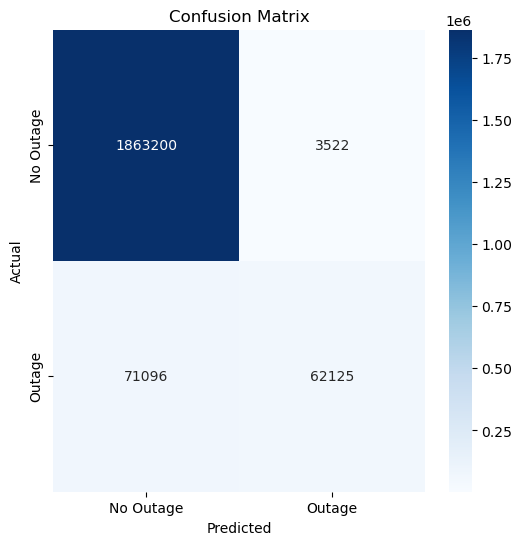

In [38]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Outage', 'Outage'], yticklabels=['No Outage', 'Outage'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

62499/62499 ━━━━━━━━━━━━━━━━━━━━ 51s 819us/step


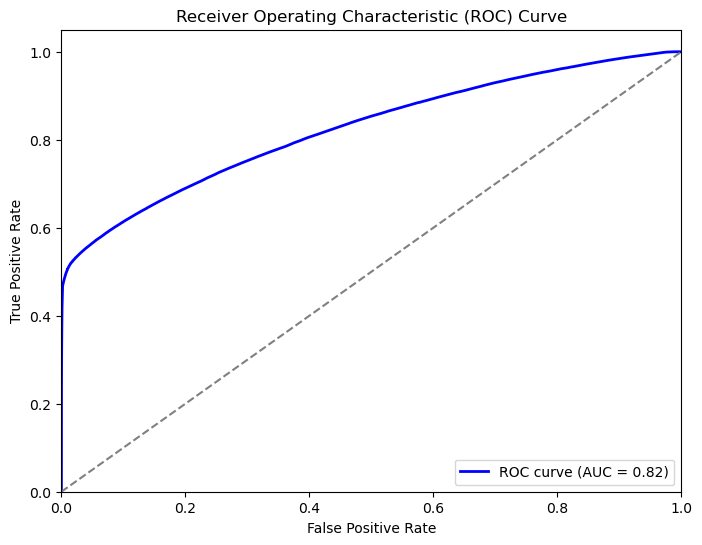

In [44]:
# Predict probabilities (for AUC/ROC, use predicted probabilities, not binary predictions)
y_pred_prob = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Deep Learning Using 0901-0907 Data